In [725]:
import numpy as np
import pandas as pd

import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from scipy import stats
from sklearn import preprocessing 
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt 
import seaborn as sns
from pandas import Timestamp

import xgboost as xgb
from xgboost import XGBRegressor 
from xgboost.sklearn import XGBClassifier # sklearn’s Grid Search with parallel processing
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from catboost import CatBoostRegressor


import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [724]:
import catboost 

In [458]:
data = pd.read_csv('DF_File_sample.csv')

In [3]:
sample.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen
0,ARW,62338-91101,ALL OTHERS - US,2015,1,1,1,205.0,0.0
1,ARW,62338-91101,ALL OTHERS - US,2015,1,1,2,2202.0,0.0
2,ARW,62338-91101,ALL OTHERS - US,2015,1,1,3,2527.0,0.0
3,ARW,62338-91101,ALL OTHERS - US,2015,1,1,4,680.0,0.0
4,ARW,62338-91101,ALL OTHERS - US,2015,1,2,5,1149.0,0.0


In [4]:
sample.shape

(15072, 9)

In [5]:
sample.dtypes

Brand              object
SKU10              object
DemandCustomer     object
Year                int64
Quarter             int64
Month_No            int64
Week_No             int64
Sales             float64
W_Nielsen         float64
dtype: object

In [9]:
var = 'Year_2'
target = 'Sales'
df_test = sample
samplet_copy = sample.copy()
col = df_test.loc[:, df_test.columns!='Sales'].columns

In [13]:
# check and remove constant columns
colsToRemove = []
for col in df_test.columns:
    if df_test.dtypes[col]!='object':
        if df_test[col].std() == 0: 
            colsToRemove.append(col)
        
# remove constant columns in the training set
df_test.drop(colsToRemove, axis=1, inplace=True)

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `0` Constant Columns

[]


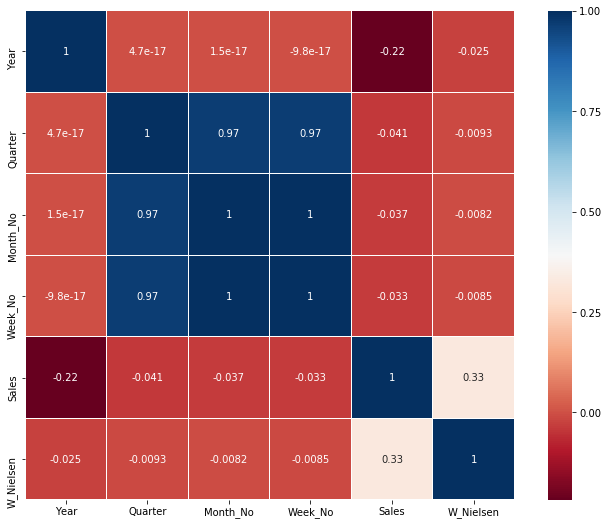

In [14]:
colormap = plt.cm.RdBu
corrmat =df_test.corr()
plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat,  linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [16]:
vars_to_object = ['Year', 'Quarter', 'Month_No', 'Week_No']
for i in vars_to_object:
    new_var = i + '_2'
    df_test[new_var] = df_test[i].astype(str)

In [17]:
df_test.columns

Index(['Brand', 'SKU10', 'DemandCustomer', 'Year', 'Quarter', 'Month_No',
       'Week_No', 'Sales', 'W_Nielsen', 'Year_2', 'Quarter_2', 'Month_No_2',
       'Week_No_2'],
      dtype='object')

In [19]:
df_test_copy = df_test.copy()

In [20]:
def var_imp(var, target, df_test):
    # Test whether a target distribution differs from a normal distribution
    norm_stats, p_norm = stats.normaltest(df_test[target])
    if p_norm < 0.05:
        # ANOVA
        var_in_formula = "Q('{}')".format(var) 
        formula = "{} ~ {}".format(target, var)
        model = ols(formula, df_test).fit() 
        table = sm.stats.anova_lm(model, typ=2) 
        stat_a, p_a = table.iloc[0,2], table.iloc[0,3]
        print('Statistics ANOVA of %s: %.3f, %.3f' % (var, stat_a, p_a))
    else:
        # kruskal
        kruskal = scipy.stats.kruskal(*[group[target].values for name, group in df_test.groupby(var)])
        stat_k, p_k = [kruskal[i] for i in range(0, 2)] 
        print('Statistics = %.3f, %.3f' % (stat_k, p_k))

In [21]:
vars_for_creation = ['Year_2', 'Quarter_2', 'Month_No_2', 'Week_No_2']

In [22]:
def var_create(vars_for_creation, df_test):
    global var_test
    var_test = vars_for_creation.copy()
    for i in range(0, len(vars_for_creation)):
        for j in range(i + 1, len(vars_for_creation)):
            if i<j:
                new_col_name = df_test.loc[:,vars_for_creation[i]].name + '_' + df_test.loc[:,vars_for_creation[j]].name
                df_test[new_col_name] = df_test.loc[:,vars_for_creation[i]] + df_test.loc[:,vars_for_creation[j]] 
                var_test.append(new_col_name)

In [23]:
var_create(vars_for_creation, df_test)

In [24]:
df_test.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen,Year_2,Quarter_2,Month_No_2,Week_No_2,Year_2_Quarter_2,Year_2_Month_No_2,Year_2_Week_No_2,Quarter_2_Month_No_2,Quarter_2_Week_No_2,Month_No_2_Week_No_2
0,ARW,62338-91101,ALL OTHERS - US,2015,1,1,1,205.0,0.0,2015,1,1,1,20151,20151,20151,11,11,11
1,ARW,62338-91101,ALL OTHERS - US,2015,1,1,2,2202.0,0.0,2015,1,1,2,20151,20151,20152,11,12,12
2,ARW,62338-91101,ALL OTHERS - US,2015,1,1,3,2527.0,0.0,2015,1,1,3,20151,20151,20153,11,13,13
3,ARW,62338-91101,ALL OTHERS - US,2015,1,1,4,680.0,0.0,2015,1,1,4,20151,20151,20154,11,14,14
4,ARW,62338-91101,ALL OTHERS - US,2015,1,2,5,1149.0,0.0,2015,1,2,5,20151,20152,20155,12,15,25


In [25]:
var_test

['Year_2',
 'Quarter_2',
 'Month_No_2',
 'Week_No_2',
 'Year_2_Quarter_2',
 'Year_2_Month_No_2',
 'Year_2_Week_No_2',
 'Quarter_2_Month_No_2',
 'Quarter_2_Week_No_2',
 'Month_No_2_Week_No_2']

In [26]:
for var in var_test:
    var_imp(var, target, df_test)

Statistics ANOVA of Year_2: 251.348, 0.000
Statistics ANOVA of Quarter_2: 16.362, 0.000
Statistics ANOVA of Month_No_2: 5.458, 0.000
Statistics ANOVA of Week_No_2: 2.568, 0.000
Statistics ANOVA of Year_2_Quarter_2: 64.017, 0.000
Statistics ANOVA of Year_2_Month_No_2: 21.350, 0.000
Statistics ANOVA of Year_2_Week_No_2: 5.498, 0.000
Statistics ANOVA of Quarter_2_Month_No_2: 5.458, 0.000
Statistics ANOVA of Quarter_2_Week_No_2: 2.568, 0.000
Statistics ANOVA of Month_No_2_Week_No_2: 2.568, 0.000


In [31]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(0, df_test.shape[1]):
    if df_test.dtypes[i]=='object':
        df_test[df_test.columns[i]] = le.fit_transform(df_test[df_test.columns[i]])

In [32]:
df_test.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen,Year_2,Quarter_2,Month_No_2,Week_No_2,Year_2_Quarter_2,Year_2_Month_No_2,Year_2_Week_No_2,Quarter_2_Month_No_2,Quarter_2_Week_No_2,Month_No_2_Week_No_2
0,0,2,0,2015,1,1,1,205.0,0.0,0,0,0,0,0,0,0,0,0,4
1,0,2,0,2015,1,1,2,2202.0,0.0,0,0,0,11,0,0,11,0,5,9
2,0,2,0,2015,1,1,3,2527.0,0.0,0,0,0,22,0,0,22,0,6,16
3,0,2,0,2015,1,1,4,680.0,0.0,0,0,0,33,0,0,33,0,7,17
4,0,2,0,2015,1,2,5,1149.0,0.0,0,0,4,44,0,4,44,1,8,18


## Modeling:

In [170]:
data = data.iloc[:, :9].copy()

In [337]:
data

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen
pre_date,,,,,,,,,
2015-01-01,0,2,0,2015,1,1,1,205.0,0.0
2015-01-08,0,2,0,2015,1,1,2,2202.0,0.0
2015-01-15,0,2,0,2015,1,1,3,2527.0,0.0
2015-01-22,0,2,0,2015,1,1,4,680.0,0.0
2015-01-29,0,2,0,2015,1,2,5,1149.0,0.0
...,...,...,...,...,...,...,...,...,...
2020-12-03,2,0,10,2020,4,12,49,0.0,0.0
2020-12-10,2,0,10,2020,4,12,50,0.0,0.0
2020-12-17,2,0,10,2020,4,12,51,0.0,0.0


In [338]:
data['year_week'] = data['Year'].astype(str) + '-' + data['Week_No'].astype(str)
data['pre_date'] = data['year_week'].apply(lambda x: datetime.datetime.strptime(x + '-4',  "%G-%V-%w"))
data.index = data['pre_date']
data.drop(['year_week', 'pre_date'], axis =1, inplace = True)

# Train / Test split
# find 80% of week
data_ser = pd.Series(data_for_pred.index.unique())
train_limit = data_ser[data_ser.index <= len(data_ser)*.8].iloc[-1]

In [352]:
train_limit

Timestamp('2018-05-01 00:00:00')

In [339]:
data.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen
pre_date,,,,,,,,,
2015-01-01,0,2,0,2015,1,1,1,205.0,0.0
2015-01-08,0,2,0,2015,1,1,2,2202.0,0.0
2015-01-15,0,2,0,2015,1,1,3,2527.0,0.0
2015-01-22,0,2,0,2015,1,1,4,680.0,0.0
2015-01-29,0,2,0,2015,1,2,5,1149.0,0.0


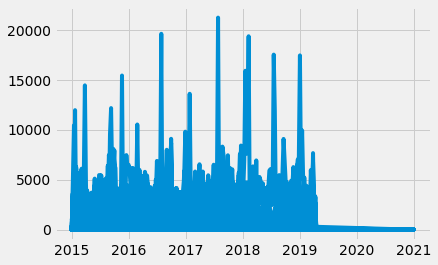

In [354]:
plt.plot(data['Sales'])

In [299]:
data_for_pred = data[(data.index < '2019-03-01')]

In [307]:
data_for_pred.index = pd.Series(data_for_pred.index).apply(lambda x: x.replace(day=1))

In [311]:
data_for_pred['Sales'] = data_for_pred.groupby(data_for_pred.index)['Sales'].transform('mean').values     

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [341]:
data_for_pred

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen
pre_date,,,,,,,,,
2015-01-01,0,2,0,2015,1,1,1,623.226667,0.0
2015-01-01,0,2,0,2015,1,1,2,623.226667,0.0
2015-01-01,0,2,0,2015,1,1,3,623.226667,0.0
2015-01-01,0,2,0,2015,1,1,4,623.226667,0.0
2015-01-01,0,2,0,2015,1,2,5,623.226667,0.0
...,...,...,...,...,...,...,...,...,...
2019-01-01,2,0,10,2019,1,2,5,694.666667,0.0
2019-02-01,2,0,10,2019,1,2,6,548.736111,0.0
2019-02-01,2,0,10,2019,1,2,7,548.736111,0.0


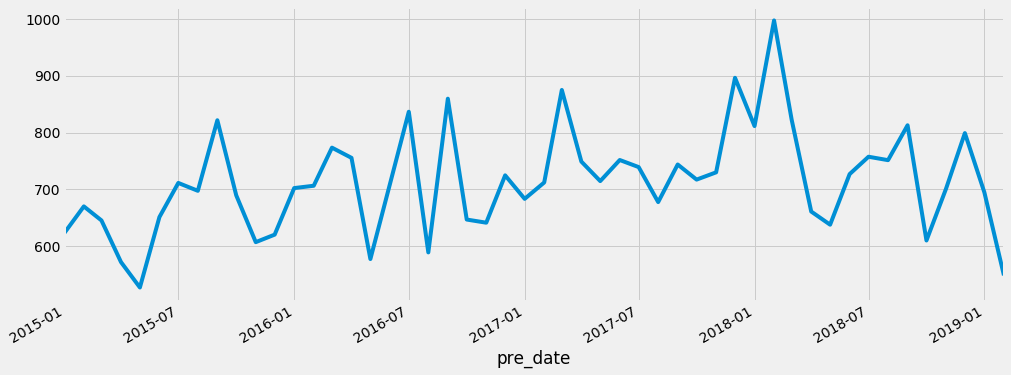

In [320]:
data_for_pred['Sales'].plot(figsize=(15, 6))
plt.show()

In [342]:
train = data_for_pred[data_for_pred.index <= train_limit]
test = data_for_pred[data_for_pred.index > train_limit]

In [ ]:
X_train = train.loc[:, train.columns!='Sales']
y_train  =  train['Sales']
X_test = test.loc[:, test.columns!='Sales']
y_test = test['Sales']

In [343]:
train.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen
pre_date,,,,,,,,,
2015-01-01,0,2,0,2015,1,1,1,623.226667,0.0
2015-01-01,0,2,0,2015,1,1,2,623.226667,0.0
2015-01-01,0,2,0,2015,1,1,3,623.226667,0.0
2015-01-01,0,2,0,2015,1,1,4,623.226667,0.0
2015-01-01,0,2,0,2015,1,2,5,623.226667,0.0


In [321]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [344]:
warnings.filterwarnings("ignore") 

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['Sales'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:137445.42939579577
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:128167.67805313594
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:107187.68808623056
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:102263.58305671274
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:107137.30100953081
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:103332.63140436514
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:104971.60866253734
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:102139.45575856637
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:126281.02931622801
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:118011.69708287533
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:101645.1344654304
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:95902.2591776348
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:101569.88628809007
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:96059.05378244437
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:98703.74666812456
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:95896.05684210428
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:92826.68578359568
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:92680.55870918611


# Fitting an ARIMA Time Series Model:

In [346]:
mod = sm.tsa.statespace.SARIMAX(train['Sales'],
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8107      0.010     84.977      0.000       0.792       0.829
ma.L1          0.0885      0.039      2.283      0.022       0.013       0.164
ma.S.L12      -1.0000      0.920     -1.087      0.277      -2.804       0.804
sigma2      2637.7973   2423.932      1.088      0.276   -2113.022    7388.616


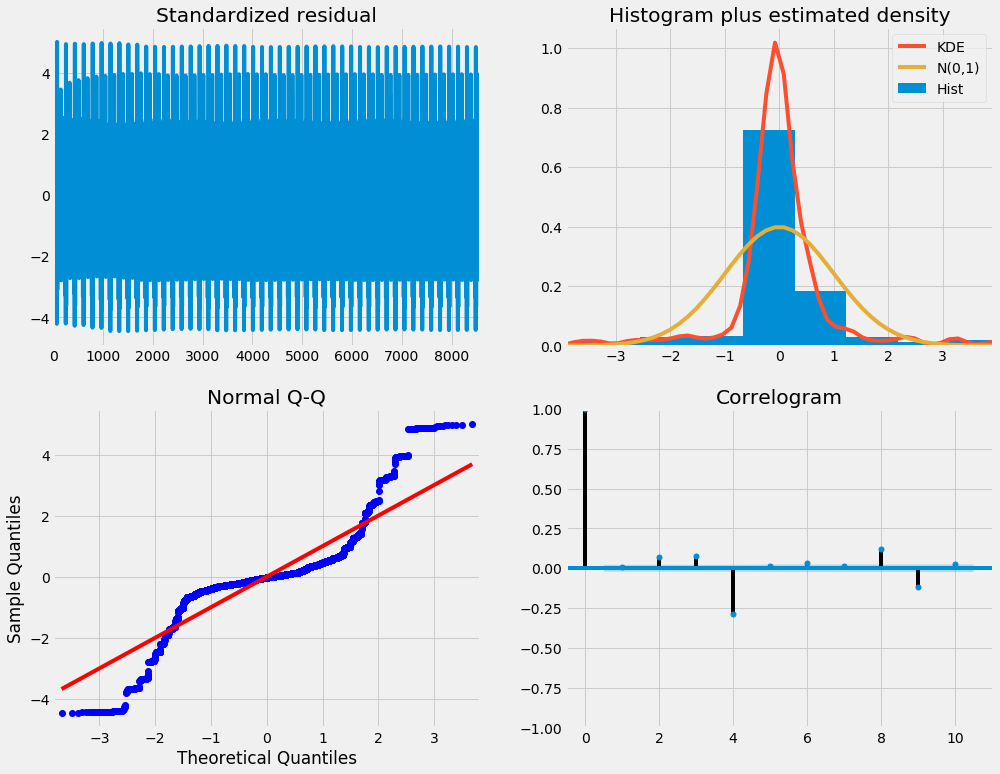

In [347]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [348]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [349]:
pred_ci

,lower Sales,upper Sales
pre_date,,
2015-01-01,-1975.819946,1975.819946
2015-01-01,-1967.478246,1983.821932
2015-01-01,-1961.177171,1989.922202
2015-01-01,-1956.504573,1994.481256
2015-01-01,-1953.162099,1997.764349
...,...,...
2018-05-01,569.706939,771.172227
2018-05-01,548.830017,750.295300
2018-05-01,550.673542,752.138816


In [350]:
y_forecasted = pred.predicted_mean
y_truth = train['Sales']['2015-01-01':]

# Compute the mean square error
mape = ((y_forecasted - y_truth).mean() / y_truth.mean())
print('MAPE of our forecasts is {}'.format(round(mape, 9)))

MAPE of our forecasts is -0.001812862


In [351]:
y_forecasted

pre_date
2015-01-01      0.000000
2015-01-01      8.171843
2015-01-01     14.372515
2015-01-01     18.988342
2015-01-01     22.301125
                 ...    
2018-05-01    670.439583
2018-05-01    649.562659
2018-05-01    651.406179
2018-05-01    651.238542
2018-05-01    651.247763
Length: 8592, dtype: float64

In [366]:
pred_uc = results.get_forecast(steps=1872)
pred_ci = pred_uc.conf_int()

In [371]:
y_forecasted = pred_uc.predicted_mean
y_truth = y_test.values

mape = ((y_forecasted - y_truth).mean() / y_truth.mean())
print('MAPE of our forecasts is {}'.format(round(mape, 9)))

MAPE of our forecasts is 0.003546635


# Starting:

In [618]:
data = pd.read_csv('DF_File_sample.csv')

In [619]:
data['SKU_Customer'] = data['DemandCustomer'] + data['SKU10']

In [620]:
data.drop(['DemandCustomer', 'SKU10'], axis =1, inplace = True)

In [621]:
data.dtypes

Brand            object
Year              int64
Quarter           int64
Month_No          int64
Week_No           int64
Sales           float64
W_Nielsen       float64
SKU_Customer     object
dtype: object

In [622]:
data = pd.get_dummies(data)

In [585]:
data.dtypes

Year                                                int64
Quarter                                             int64
Month_No                                            int64
Week_No                                             int64
Sales                                             float64
W_Nielsen                                         float64
Brand_ARW                                           uint8
Brand_FIN                                           uint8
Brand_LYS                                           uint8
SKU_Customer_ALL OTHERS - US19200-79329             uint8
SKU_Customer_ALL OTHERS - US51700-77050             uint8
SKU_Customer_ALL OTHERS - US62338-91101             uint8
SKU_Customer_ALL OTHERS - US62338-92944             uint8
SKU_Customer_ALL OTHERS - US62338-99058             uint8
SKU_Customer_AMAZON19200-79329                      uint8
SKU_Customer_AMAZON51700-77050                      uint8
SKU_Customer_AMAZON62338-91101                      uint8
SKU_Customer_A

In [567]:
data_with_LE = pd.read_csv('DF_File_sample.csv')
data_with_LE['SKU_Customer'] = data_with_LE['DemandCustomer'] + data_with_LE['SKU10']
data_with_LE.drop(['DemandCustomer', 'SKU10'], axis =1, inplace = True)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(0, data_with_LE.shape[1]):
    if data_with_LE.dtypes[i]=='object':
        data_with_LE[data_with_LE.columns[i]] = le.fit_transform(data_with_LE[data_with_LE.columns[i]])

## sklearn:

In [661]:
data['year_week'] = data['Year'].astype(str) + '-' + data['Week_No'].astype(str)
data['pre_date'] = data['year_week'].apply(lambda x: datetime.datetime.strptime(x + '-4',  "%G-%V-%w"))
# data.drop(['year_week', 'pre_date'], axis =1, inplace = True)


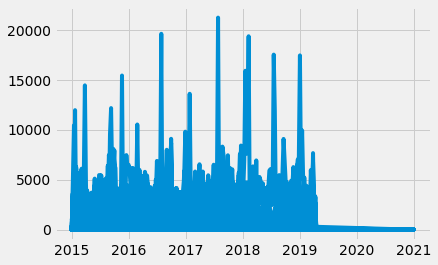

In [400]:
plt.plot(data['Sales'])

In [662]:
data.drop('year_week', axis=1, inplace = True)

In [625]:
Null_Sales = data[data.Sales==0].groupby('pre_date').sum().Sales

In [470]:
Null_Sales[Null_Sales>40]

pre_date
2019-04-18    48
2019-04-25    48
2019-05-02    48
2019-05-09    48
2019-05-16    48
              ..
2020-12-03    48
2020-12-10    48
2020-12-17    48
2020-12-24    48
2020-12-31    48
Name: Sales, Length: 90, dtype: int64

In [426]:
Null_Sales[Null_Sales==48]

pre_date
2019-04-18    48
2019-04-25    48
2019-05-02    48
2019-05-09    48
2019-05-16    48
              ..
2020-12-03    48
2020-12-10    48
2020-12-17    48
2020-12-24    48
2020-12-31    48
Name: Sales, Length: 90, dtype: int64

In [663]:
new_data = data[data.pre_date < '2019-04-18']

In [664]:
data_ser = pd.Series(sorted(new_data['pre_date'].unique()))

In [665]:
test = new_data[data.pre_date >= data_ser.iloc[-26]]

In [666]:
train = new_data[data.pre_date < data_ser.iloc[-26]]

In [668]:
new_data.drop('pre_date', axis =1, inplace = True)
train.drop('pre_date', axis =1, inplace = True)
test.drop('pre_date', axis =1, inplace = True)

In [669]:
# All data 
X_train = train.loc[:, train.columns!='Sales']
X_test = test.loc[:, test.columns!='Sales']
y_train = train['Sales']
y_test = test['Sales']

# Modeling:

In [483]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (np.mean(np.abs((y_true - y_pred))) * 100 / np.mean(np.abs((y_true)))) 

## Ridge regression:

In [479]:
from sklearn.linear_model import Ridge

In [604]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [605]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.linear_model import Ridge

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

In [606]:
for this_alpha in [.001, .05, .01, 0, 1, 3, 5, 10, 20, 50, 100, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    predicted = linridge.predict(X_test_scaled); 
    
    MAPE=mean_absolute_percentage_error(y_test, predicted);
    print(MAPE);

51.155543555557266
51.118027089801295
51.14837288235791
51.26267495119128
50.762365585945524
50.81293983716929
51.073007115365535
51.88249066088715
53.54441269383765
58.616327609083086
66.21307900916284
99.40746451460998


In [ ]:
linridge = Ridge(alpha = 0).fit(X_train_scaled, y_train)
predicted = linridge.predict(X_test_scaled);

# Lasso regression:

In [497]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for alpha in [0.001, .002, .003, 0.005, 0.01, .05, 0.1, .5]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train_scaled, y_train)
    r2_train = linlasso.score(X_train_scaled, y_train)
    r2_test = linlasso.score(X_test_scaled, y_test)
    predicted = linlasso.predict(X_test_scaled); 
    
    MAPE=mean_absolute_percentage_error(y_test, predicted);
    print(MAPE);

55.83276349532877
55.83174287922704
55.83017647354451
55.82678540060854
55.82006364456225
55.76680475536
55.713133268106276
55.79566824956008


## Support Vector Machines:

In [499]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for C in [0.5, 1, 2, 3, 5, 10, 20, 50, 100, 200]:
    svr=SVR(kernel='linear', C=C, epsilon=0.6).fit(X_train_scaled, y_train)
    r2_train = svr.score(X_train_scaled, y_train)
    r2_test = svr.score(X_test_scaled, y_test)
    predicted = svr.predict(X_test_scaled);
    
    
    MAPE=mean_absolute_percentage_error(y_test, predicted);
    print(MAPE);

86.36034432599499
82.14133315286635
75.92209376336604
71.38506881482469
65.12939805288771
57.273565407631295
53.37278653307787
50.7332220754958
50.67034964960801
50.59368424444143


## With LE:

In [534]:
# Only for test
data_with_LE = data_with_LE.loc[new_data.index, ]
train_LE = data_with_LE.loc[train.index, ]
test_LE = data_with_LE.loc[test.index, ]
X_train_LE, X_test_LE, y_train_LE, y_test_LE = train_test_split(train_LE.loc[:, train_LE.columns!='Sales'], train_LE['Sales'], test_size = 0.2, random_state = 0)

In [556]:
X_train_LE.shape

(6912, 7)

### Lasso regression_LE:

In [557]:
alpha = 0.001

In [559]:
linlasso_LE = Lasso(alpha, max_iter = 10000).fit(X_train_scaled_LE, y_train_LE)
r2_train_LE = linlasso.score(X_train_scaled_LE, y_train_LE)

In [560]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled_LE = scaler.fit_transform(X_train_LE)
X_test_scaled_LE = scaler.transform(X_test_LE)

for alpha in [0.001, .002, .003, 0.005, 0.01, .05, 0.1, .5]:
    linlasso_LE = Lasso(alpha, max_iter = 10000).fit(X_train_scaled_LE, y_train_LE)
    r2_train_LE = linlasso_LE.score(X_train_scaled_LE, y_train_LE)
    r2_test_LE = linlasso_LE.score(X_test_scaled_LE, y_test_LE)
    predicted_LE = linlasso_LE.predict(X_test_scaled_LE); 
    
    MAPE_LE = mean_absolute_percentage_error(y_test_LE, predicted_LE);
    print(MAPE_LE);

89.47280727736612
89.47290646187247
89.47300564674936
89.47320401575676
89.47369992809186
89.47852222649374
89.4892511639635
89.67413671609809


### create data for validation:

In [681]:
train['year_week'] = train['Year'].astype(str) + '-' + train['Week_No'].astype(str)
train['pre_date'] = train['year_week'].apply(lambda x: datetime.datetime.strptime(x + '-4',  "%G-%V-%w"))

# Train / Train split to all and valid
# find 80% of week
data_ser_val = pd.Series(sorted(train['pre_date'].unique()))
train_val_limit = data_ser[data_ser.index <= len(data_ser)*.8].iloc[-1]


In [673]:
train_val_limit

Timestamp('2018-06-07 00:00:00')

In [682]:
train.drop('year_week', axis = 1, inplace = True)

In [683]:
train_val = train[train.pre_date <= train_val_limit]
test_val = train[train.pre_date > train_val_limit]

In [684]:
train.drop('pre_date', axis =1, inplace = True)
train_val.drop('pre_date', axis =1, inplace = True)
test_val.drop('pre_date', axis =1, inplace = True)

In [685]:
X_train_val = train_val.loc[:, train_val.columns!='Sales']
X_test_val = test_val.loc[:, test_val.columns!='Sales']
y_train_val = train_val['Sales']
y_test_val = test_val['Sales']

In [686]:
X_train_val.shape

(8640, 56)

In [687]:
X_train_val.dtypes

Year                                         int64
Quarter                                      int64
Month_No                                     int64
Week_No                                      int64
W_Nielsen                                  float64
Brand_ARW                                    uint8
Brand_FIN                                    uint8
Brand_LYS                                    uint8
SKU_Customer_ALL OTHERS - US19200-79329      uint8
SKU_Customer_ALL OTHERS - US51700-77050      uint8
SKU_Customer_ALL OTHERS - US62338-91101      uint8
SKU_Customer_ALL OTHERS - US62338-92944      uint8
SKU_Customer_ALL OTHERS - US62338-99058      uint8
SKU_Customer_AMAZON19200-79329               uint8
SKU_Customer_AMAZON51700-77050               uint8
SKU_Customer_AMAZON62338-91101               uint8
SKU_Customer_AMAZON62338-92944               uint8
SKU_Customer_AMAZON62338-99058               uint8
SKU_Customer_DOLLAR GENERAL62338-91101       uint8
SKU_Customer_DOLLAR GENERAL6233

# XGB:

In [756]:
def run_xgb(train_X, train_y, val_X, val_y, test_X, test_y):
    params = {'objective': 'reg:linear', 
              'eval_metric': 'rmse',
              'eta': 0.005,
              'max_depth': 5, 
              'subsample': 0.7, 
              'colsample_bytree': 0.5,
              'alpha':0.8,
              'lambda':0.45,
              'random_state': 42, 
              'silent': True}
              
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    model_xgb = xgb.train(params, 
                          tr_data, 
                          2000, 
                          watchlist, 
                          maximize=False, 
                          early_stopping_rounds = 1000, 
                          verbose_eval=100)

    dtest = xgb.DMatrix(test_X)
    
    xgb_pred_y = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)
    return xgb_pred_y, model_xgb

In [757]:
pred_test_xgb, model_xgb = run_xgb(X_train_val, y_train_val, X_test_val, y_test_val, taest.loc[:, test.columns!='Sales'])

[0]	train-rmse:1424.94	valid-rmse:1510.63
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 1000 rounds.
[100]	train-rmse:1141.98	valid-rmse:1219.1
[200]	train-rmse:976.046	valid-rmse:1052.35
[300]	train-rmse:876.127	valid-rmse:950.393
[400]	train-rmse:810.183	valid-rmse:887.684
[500]	train-rmse:763.065	valid-rmse:842.773
[600]	train-rmse:731.382	valid-rmse:814.304
[700]	train-rmse:709.651	valid-rmse:798.146
[800]	train-rmse:691.206	valid-rmse:786.193
[900]	train-rmse:677.062	valid-rmse:777.991
[1000]	train-rmse:665.922	valid-rmse:771.317
[1100]	train-rmse:656.126	valid-rmse:766.348
[1200]	train-rmse:648.556	valid-rmse:762.821
[1300]	train-rmse:641.565	valid-rmse:760.017
[1400]	train-rmse:636.019	valid-rmse:758.088
[1500]	train-rmse:629.682	valid-rmse:755.848
[1600]	train-rmse:624.563	valid-rmse:753.676
[1700]	train-rmse:619.582	valid-rmse:750.878
[1800]	train-rmse:614.077	valid-rmse:749.099
[1900]	trai

In [759]:
mean_absolute_percentage_error(test['Sales'], pred_test_xgb)

55.14589984514644

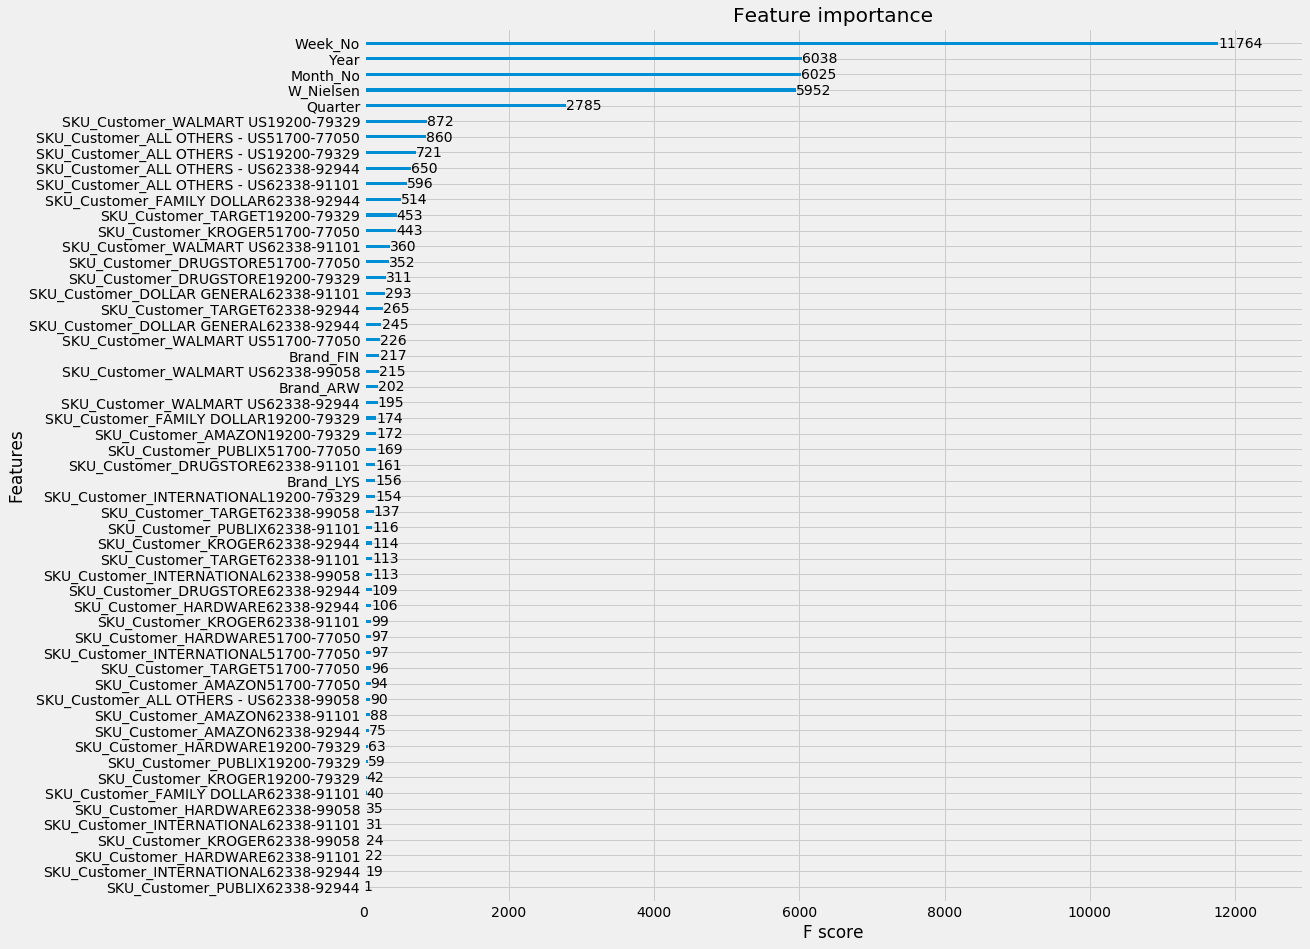

In [735]:
xgb.plot_importance(model_xgb)
plt.rcParams['figure.figsize'] = [25, 25]
plt.show()

# LightGBM:

In [789]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 35,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "random_seed": 42
    }
    

    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [790]:
pred_test_lgb, model_lgb, model_lgb = run_lgb(X_train_val, y_train_val, X_test_val, y_test_val, test.loc[:, test.columns!='Sales'])

Training until validation scores don't improve for 100 rounds.
[150]	training's rmse: 964.485	valid_1's rmse: 1044.42
[300]	training's rmse: 828.85	valid_1's rmse: 920.788
[450]	training's rmse: 763.44	valid_1's rmse: 865.989
[600]	training's rmse: 728.83	valid_1's rmse: 840.303
[750]	training's rmse: 709.54	valid_1's rmse: 828.657
[900]	training's rmse: 696.528	valid_1's rmse: 824.314
[1050]	training's rmse: 687.369	valid_1's rmse: 818.826
[1200]	training's rmse: 679.846	valid_1's rmse: 813.651
[1350]	training's rmse: 673.6	valid_1's rmse: 810.04
[1500]	training's rmse: 667.467	valid_1's rmse: 805.063
[1650]	training's rmse: 662.313	valid_1's rmse: 799.725
[1800]	training's rmse: 657.486	valid_1's rmse: 796.828
[1950]	training's rmse: 653.178	valid_1's rmse: 794.692
[2100]	training's rmse: 649.145	valid_1's rmse: 793.152
[2250]	training's rmse: 645.365	valid_1's rmse: 791.526
[2400]	training's rmse: 641.665	valid_1's rmse: 788.709
[2550]	training's rmse: 638.198	valid_1's rmse: 787.31

In [791]:
mean_absolute_percentage_error(test['Sales'], pred_test_lgb)

56.08806533593276

In [781]:
def run_cat_b(train_X, train_y, val_X, val_y, test_X):
    cb_model = CatBoostRegressor(iterations=1000, 
                                learning_rate=0.1, 
                                depth=8, 
                                l2_leaf_reg=20,  
                                eval_metric='RMSE', 
                                metric_period=50, 
                                od_type='Iter', 
                                od_wait=45, 
                                random_seed=17, 
                                allow_writing_files=False)
                                
    cb_model.fit(train_X, 
                 train_y, 
                 eval_set=(val_X, val_y), 
                 cat_features=[], 
                 use_best_model=True, 
                 verbose=True)
                 
    pred_test_y = model.predict(test_X, num_iteration=cb_model.best_iteration)
    return pred_test_y, cb_model, evals_result 
    

In [782]:
pred_test_cat, cb_model, model_cat = run_cat_b(X_train_val, y_train_val, X_test_val, y_test_val, test.loc[:, test.columns!='Sales'])

0:	learn: 1349.9281772	test: 1434.6373353	best: 1434.6373353 (0)	total: 34ms	remaining: 34s
50:	learn: 770.7028959	test: 842.0131512	best: 842.0131512 (50)	total: 2.36s	remaining: 44s
100:	learn: 745.0598889	test: 827.1139359	best: 826.9353089 (96)	total: 4.79s	remaining: 42.6s
150:	learn: 732.5425601	test: 819.0952730	best: 819.0754132 (148)	total: 7.34s	remaining: 41.3s
200:	learn: 721.6030746	test: 816.1001068	best: 816.1001068 (200)	total: 10s	remaining: 39.9s
250:	learn: 712.7106311	test: 814.5210584	best: 814.5210584 (250)	total: 12.5s	remaining: 37.2s
300:	learn: 705.8687921	test: 808.0286846	best: 808.0286846 (300)	total: 14.7s	remaining: 34.2s
350:	learn: 700.7003901	test: 801.9356469	best: 801.8357940 (341)	total: 16.8s	remaining: 31s
400:	learn: 693.8280422	test: 799.6687897	best: 799.4759033 (396)	total: 18.9s	remaining: 28.2s
450:	learn: 689.6057924	test: 796.2939750	best: 796.1580935 (448)	total: 21.2s	remaining: 25.7s
500:	learn: 686.4600256	test: 792.6812389	best: 792.6

AttributeError: 'CatBoostRegressor' object has no attribute 'best_iteration'

In [767]:
mean_absolute_percentage_error(test['Sales'], pred_test_cat)

56.07953217377104

## Tunning Parameters:

In [718]:
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.005,
                 max_depth=5,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.8,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [719]:
learning_rate = np.arange(0.01, 0.5, 0.02)
parameters = dict(learning_rate=learning_rate)

print_parameters(learning_rate, 'learning_rate', parameters)

NameError: name 'print_parameters' is not defined

In [ ]:
n_estimators = range(100, 1000, 100)
parameters = dict(n_estimators=n_estimators)

print_parameters(n_estimators, 'n_estimators', parameters)

In [ ]:
max_depth = range(0, 5)
parameters = dict(max_depth=max_depth)

print_parameters(max_depth, 'max_depth', parameters)

In [ ]:
subsample = np.arange(0.2, 1., 0.2)
parameters = dict(subsample=subsample)

print_parameters(subsample, 'subsample', parameters)

In [ ]:
colsample_bytree = np.arange(0.2, 1.2, 0.2)
parameters = dict(colsample_bytree=colsample_bytree)

print_parameters(colsample_bytree, 'colsample_bytree', parameters)

In [ ]:
gamma = np.arange(0.001, 0.1, 0.02)
parameters = dict(gamma=gamma)

print_parameters(gamma, 'gamma', parameters)

In [ ]:
min_child_weight = np.arange(0.5, 2.0, 0.2)
parameters = dict(min_child_weight=min_child_weight)

print_parameters(min_child_weight, 'min_child_weight', parameters)

In [ ]:
parameters = {  
                'colsample_bytree':[1],
                'subsample':[0.4,0.6],
                'gamma':[0.041],
                'min_child_weight':[1.1,1.3],
                'max_depth':[3,5],
                'learning_rate':[0.2, 0.25],
                'n_estimators':[400],                                                                    
                'reg_alpha':[0.75],
                'reg_lambda':[0.45],
                'seed':[10]

In [ ]:
grid_search = GridSearchCV(estimator = xgb_model,
                        param_grid = parameters,
                        scoring = 'neg_mean_squared_error',
                        cv = 5,
                        n_jobs = -1)

In [ ]:
xgb_model = grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
accuracies = cross_val_score(estimator=xgb_model, X=X_train, y=y_train, cv=10)
accuracies.mean()
y_pred = xgb_model.predict(X_test)
y_pred = np.floor(np.expm1(y_pred))